# Machine Learning
## Practical 1

<b> Ohasim Akkram <br>
    4094

In [57]:
# Importing Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [188]:
# Reading data
df=pd.read_excel("computer.xlsx")
df

,Age,Income,Student,Credit_Rating,Buys_Computer
0,<=30,high,no,fair,no
1,<=30,high,no,excellent,no
2,31-40,high,no,fair,yes
3,>40,medium,no,fair,yes
4,>40,low,yes,fair,yes
5,>40,low,yes,excellent,no
6,31-40,low,yes,excellent,yes
7,<=30,medium,no,fair,no
8,<=30,low,yes,fair,yes
9,>40,medium,yes,fair,yes


In [189]:
df.info()
print(df.shape)
print("All columns are categorical data")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            14 non-null     object
 1   Income         14 non-null     object
 2   Student        14 non-null     object
 3   Credit_Rating  14 non-null     object
 4   Buys_Computer  14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes
(14, 5)
All columns are categorical data


## Encoding 

In [190]:
df=df.replace({'Student':{'yes':1,'no':0}})
categorical_cols=['Age','Income','Credit_Rating']
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(handle_unknown='ignore',sparse=False).fit(df[categorical_cols])
encoded_cols=list(encoder.get_feature_names(categorical_cols))
df[encoded_cols]=encoder.transform(df[categorical_cols])
df['buys_computer']=df['Buys_Computer']
df=df.drop(columns=['Age','Income','Credit_Rating','Buys_Computer'])
df

,Student,Age_31-40,Age_<=30,Age_>40,Income_high,Income_low,Income_medium,Credit_Rating_excellent,Credit_Rating_fair,buys_computer
0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,no
1,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,no
2,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,yes
3,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,yes
4,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,yes
5,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,no
6,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,yes
7,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,no
8,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,yes
9,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,yes


# Naive Bayes Classification

In [191]:
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed 
        
        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
        # numerator = np.exp(-((x-mean)**2 / (2 * var)))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
     

    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

In [192]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [193]:
# df1= pd.read_csv("iris.csv")
# # shuffle dataset with sample
# df1 = df1.sample(frac=1, random_state=1).reset_index(drop=True)
# # df shape
# print(df1.shape)
# # set features and target
# X, y = df1.iloc[:, :-1], df1.iloc[:, -1]


# # # split on train and test 0.7/0.3
# X_train, X_test, y_train, y_test = X[:100], X[100:], y[:100], y[100:]

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [194]:
model=NaiveBayesClassifier()
model.fit(X_train,y_train)
y_preds=model.predict(X_test)
y_preds

['no', 'no', 'no', 'no', 'no']

In [195]:
y_test

13     no
7      no
2     yes
1      no
6     yes
Name: buys_computer, dtype: object

In [196]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_preds)

0.6

# Simple Regression
## One Variable (Using Least Square Method)

In [197]:
# reading data
df=pd.read_csv("advertising.csv")
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [198]:
df.shape

(200, 4)

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


<AxesSubplot:xlabel='TV', ylabel='Sales'>

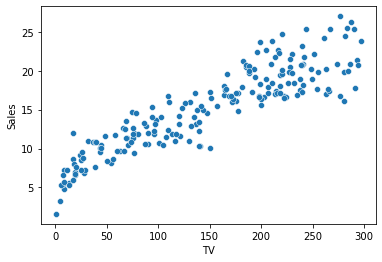

In [200]:
# Relation b/w Sales and other features
sns.scatterplot(x=df['TV'],y=df['Sales'])

<AxesSubplot:xlabel='Radio', ylabel='Sales'>

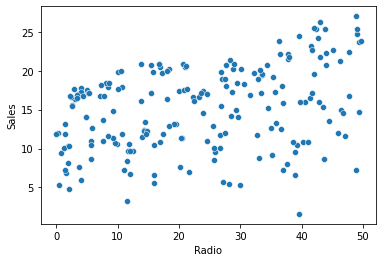

In [201]:
sns.scatterplot(x=df['Radio'],y=df['Sales'])

<AxesSubplot:xlabel='Newspaper', ylabel='Sales'>

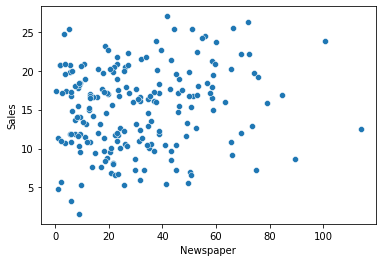

In [202]:
sns.scatterplot(x=df['Newspaper'],y=df['Sales'])

<b> TV feature seems to be showing most correlated with sales. <br>
    So we will do TV v/s Sales regression

In [203]:
x=df[['TV']]
y=df[['Sales']]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [204]:
# Calculating SSxx
x_mean=x_train['TV'].mean()
x_train['diffx']=x_mean-x_train['TV']
x_train['diffx_squared']=x_train['diffx']**2
SSxx=x_train['diffx_squared'].sum()
SSxx

1014060.2842142858

In [205]:
# Calulating SSxy
y_mean=y_train['Sales'].mean()
y_train['diffy']=y_mean-y_train['Sales']
SSxy=(x_train['diffx']*y_train['diffy']).sum()
SSxy

54492.92171428571

In [206]:
# Slope
m=SSxy/SSxx
print('Slope : ',m)

Slope :  0.05373735917141052


In [207]:
# Calculating y intercept of regression line
c=y_mean-m*x_mean
c

7.28564629257732

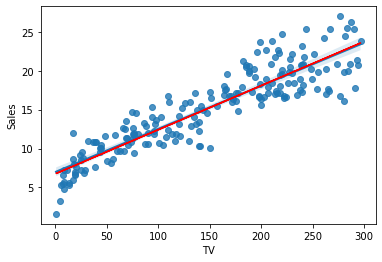

In [208]:
# Plotting Regression line
sns.regplot(x,y)
plt.plot(x,6.75730140401312+x*0.05667996845347576,'r')

<b> That means.. <br>
    Sales=6.974821488229898 + TV * 0.055464770469558854

### Predicting sales

In [209]:
y_test['Predicted']=m*x_test+c
y_test[:20]

,Sales,Predicted
105,15.0,14.696028
198,25.5,22.525561
7,13.2,13.744877
26,15.0,14.964715
23,20.5,19.553885
101,23.8,23.213400
161,13.3,11.890938
29,10.5,11.079504
142,20.1,19.134734
189,6.7,8.290535


### R2 Score

In [210]:
from sklearn.metrics import r2_score
r2=r2_score(y_test['Sales'],y_test['Predicted'])
print("R2 score : ",r2)

R2 score :  0.847740749224334


# Linear Regression in Two Variables

<B> Taking tv and newspaper as independent variables

In [242]:
X=df.iloc[:,:-2]
y=df.iloc[:,-1]
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(140, 2) (60, 2) (140,) (60,)


In [243]:
def cost_function(X, y, w, b):
    """
    Parameters:
    X: features
    y: target values
    w: weights
    b: bias
    
    Returns:
    cost: cost with current weights and bias
    """
    cost = np.sum((((X.dot(w) + b) - y) ** 2) / (2*len(y)))
    return cost

In [244]:
def gradient_descent_function(X, y, w, b, alpha=0.01, epochs=1000):
    """
    Parameters:
    X: features
    y: target values
    w: initial weights
    b: initial bias
    alpha: learning rate
    epochs: number of iterations
    
    Returns:
    costs: cost per epoch
    w: finalised weights
    b: finalised bias
    """
    m = len(y)
    costs = [0] * epochs
    
    for epoch in range(epochs):
        # Calculate the value -- Forward Propagation
        z = X.dot(w) + b
        
        # Calculate the losses
        loss = z - y
        
        # Calculate gradient descent
        weight_gradient = X.T.dot(loss) / m
        bias_gradient = np.sum(loss) / m
        
        # Update weights and bias
        w = w - alpha*weight_gradient
        b = b - alpha*bias_gradient
        
        # Store current lost
        cost = cost_function(X, y, w, b)
        costs[epoch] = cost
        
    return w, b, costs

In [245]:
# Initial random weights
w = np.random.randn(X_train.shape[1])
# Initial bias
b = 0
weights, bias, costs = gradient_descent_function(X_train, y_train, w, b, epochs=2500);
print(weights)
print(bias)

[4.73857307 1.54906452]
15.052946261935988


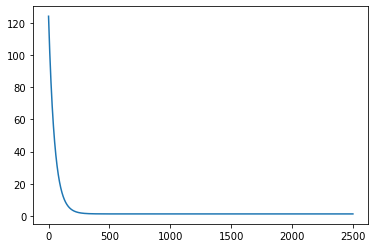

In [246]:
plt.plot(costs)
plt.show()

In [247]:
def predict(X, w, b):
    return X.dot(w) + b

In [265]:
y_preds=predict(X_test,weights,bias)
y_preds

array([15.86298927,  8.92105852, 13.78389252,  9.65541929, 15.13371874,
       21.25119657, 14.69237246, 19.41947232, 16.80118273,  8.99051363,
       10.77327954, 20.54384506,  8.18930741,  6.78379669,  5.25013824,
       12.55041767, 15.61709356, 20.03432124,  7.79347403, 19.46527904,
        7.67038206, 12.03650356,  9.40678925,  8.46338091, 21.79835423,
        9.41808931, 13.42035902, 15.45509019, 11.35442193, 20.81899248,
       11.70734205, 22.18402602, 24.89459008,  7.23046247, 17.09815458,
       20.14941391, 20.75459312, 19.30615911, 16.82443385, 10.32297468,
        9.24855964, 21.46898907, 13.70559789, 21.27152977, 18.88340105,
       15.77162958, 17.77075569, 17.23900457, 17.85414615, 12.05463439,
       12.42188712, 17.83506605, 23.62622574, 15.10506353,  9.79066155,
       12.97000406,  8.74755145, 24.91967076, 14.13198057, 19.34561248])

In [270]:
tab=pd.DataFrame({'Actual':y_test,'Predicted':y_preds})
tab[:20]

,Actual,Predicted
50,16.4,15.862989
127,11.9,8.921059
37,14.7,13.783893
149,10.1,9.655419
19,14.6,15.133719
104,20.7,21.251197
179,17.6,14.692372
53,21.2,19.419472
162,19.9,16.801183
158,7.3,8.990514


In [256]:
# R2 score
rss=np.sum((y_preds-y_test)**2)
tss=np.sum((y_test-y_test.mean())**2)
r2=1-(rss/tss)
print("R2 Score : ",r2)

R2 Score :  0.8804621134212637
